# capcomm
##### A program to specify polygon or multipolygon shape and infer ecological community structure within based on species occurrence records.

In [5]:
import pandas as pd
import geopandas
import requests
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import src.capcomm as capcomm

## Read in shapefile data

In [111]:
capcomm.large

,Name,Country,Source,geometry
0,Taurus Mountains,Turkey,None,"POLYGON ((41.33734 40.02080, 41.45628 40.01015..."
1,Hindukush-Himalaya,"AF, BD, BT, CN, IN, MM, NP, PK",None,"MULTIPOLYGON (((96.91337 25.18540, 96.90844 24..."
2,Qilian Shan,China,"Knaurs (1999): Knaurs grosser Weltatlas, Augsb...","POLYGON ((92.38338 39.21083, 92.77361 39.45829..."
3,Tien Shan,"China, Kazakhstan, Kyrgyzstan, Uzbekistan","Knaurs (1999): Knaurs grosser Weltatlas, Augsb...","POLYGON ((88.03505 43.41852, 88.03765 43.41515..."
4,Kapuas Mountains,"Indonesia, Malaysia",Zim24Travel,"POLYGON ((111.64782 -0.89647, 111.87210 -0.436..."
5,Southern Alps New Zealand,New Zealand,"Knaurs (1999): Knaurs grosser Weltatlas, Augsb...","POLYGON ((167.71730 -46.15126, 167.79345 -45.9..."
6,Lesser Caucasus,"Georgia, Azerbaijan, Turkey",034 Caucasus.jpg,"POLYGON ((44.57084 39.93052, 44.58090 39.99422..."
7,Great Dividing Range,Australia,"Knaurs (1999): Knaurs grosser Weltatlas, Augsb...","MULTIPOLYGON (((151.05582 -34.22740, 150.73399..."
8,Sierra Madre de Chiapas,"Mexico, Guatemala, Honduras, El Salvador",046 Mexico1.jpg,"MULTIPOLYGON (((-88.69241 17.14915, -88.68943 ..."
9,Cordillera de los Andes,"VE, CO, Ecuador, Peru, Bolivia, Argentina, Chile","Knaurs (1999): Knaurs grosser Weltatlas, Augsb...","MULTIPOLYGON (((-69.42098 -44.00736, -69.42316..."


<AxesSubplot:>

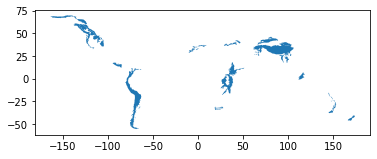

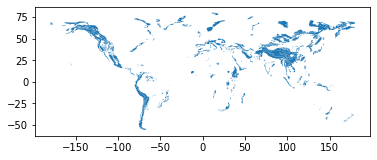

In [7]:
# "large-scale set" of mountain polygons (17 polygons represent largest continuous mountain ranges)
large = geopandas.read_file("../data/GMBA_mountain_inventory_V1.2_supplementary_large-scale-set/GMBA mountain inventory_V1.2-LargeScale.shp")
large.plot()

# Mountain polygons for "entire_world" (1,048 polygons)
world = geopandas.read_file("../data/GMBA_mountain_inventory_V1.2_entire_world/GMBA Mountain Inventory_v1.2-World.shp")
world[world.Country == "United States of America"]
world.plot()

## Classes

In [8]:
# # Not sure what Henry meant to do here, but the Data class works how I want it to with Polygon(name, poly),
# but doesn't work here. See below.
class Data:
    """
    Create individual Polygon objects for each row of shape data
    """

    # HL: GeoDataFrames already have a geometry column with Polygon objects, so it might be easier to save the whole thing to a class
    # object and subset them out as needed.  Relatedly, I don't know if you need a separate draw function, unles you want it to do 
    # something more specific than display shapes.
    def __init__(self, gdf):
        self.gdf = gdf
        self.polygons = [
            (name, poly) for name, poly in [
                gdf.iloc[i][["Name", "geometry"]]
                for i in range(len(gdf))]
        ]

In [48]:
class Data:
    """
    Create individual Polygon objects for each row of shape data
    """
    def __init__(self, dataframe):       
        self.region = [
            Polygon(name, poly) for name, poly in [
                dataframe.iloc[i][["Name", "geometry"]]
                for i in range(len(dataframe))]
        ]
        
    def draw(self, index):
        """
        TODO...
        """
        print(self.region[index].name)
        self.region[index].polygon

In [49]:
l = Data(large)

In [112]:
capcomm.large

,Name,Country,Source,geometry
0,Taurus Mountains,Turkey,None,"POLYGON ((41.33734 40.02080, 41.45628 40.01015..."
1,Hindukush-Himalaya,"AF, BD, BT, CN, IN, MM, NP, PK",None,"MULTIPOLYGON (((96.91337 25.18540, 96.90844 24..."
2,Qilian Shan,China,"Knaurs (1999): Knaurs grosser Weltatlas, Augsb...","POLYGON ((92.38338 39.21083, 92.77361 39.45829..."
3,Tien Shan,"China, Kazakhstan, Kyrgyzstan, Uzbekistan","Knaurs (1999): Knaurs grosser Weltatlas, Augsb...","POLYGON ((88.03505 43.41852, 88.03765 43.41515..."
4,Kapuas Mountains,"Indonesia, Malaysia",Zim24Travel,"POLYGON ((111.64782 -0.89647, 111.87210 -0.436..."
5,Southern Alps New Zealand,New Zealand,"Knaurs (1999): Knaurs grosser Weltatlas, Augsb...","POLYGON ((167.71730 -46.15126, 167.79345 -45.9..."
6,Lesser Caucasus,"Georgia, Azerbaijan, Turkey",034 Caucasus.jpg,"POLYGON ((44.57084 39.93052, 44.58090 39.99422..."
7,Great Dividing Range,Australia,"Knaurs (1999): Knaurs grosser Weltatlas, Augsb...","MULTIPOLYGON (((151.05582 -34.22740, 150.73399..."
8,Sierra Madre de Chiapas,"Mexico, Guatemala, Honduras, El Salvador",046 Mexico1.jpg,"MULTIPOLYGON (((-88.69241 17.14915, -88.68943 ..."
9,Cordillera de los Andes,"VE, CO, Ecuador, Peru, Bolivia, Argentina, Chile","Knaurs (1999): Knaurs grosser Weltatlas, Augsb...","MULTIPOLYGON (((-69.42098 -44.00736, -69.42316..."


Cordillera de los Andes


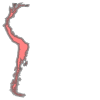

In [113]:
print(l.region[9].name)
l.region[9].polygon

In [24]:
# how to get this to draw polygon like above that is printed to stdout
l.draw(9)

Cordillera de los Andes


West Coast


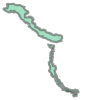

In [29]:
west = l.region[12]
print(west.name)
west.polygon

In [ ]:
if __name__ == "__main__":

    # Read in mountain polygons
    world = geopandas.read_file("../data/GMBA_mountain_inventory_V1.2_entire_world/GMBA Mountain Inventory_v1.2-World.shp")

    # get example polygon (load with geopandas from ...)
    example_poly = world.geometry[778]

    # create example Polygon object
    pol = Polygon(name="test", polygon=example_poly)
    print(pol)

    # get json records from
    r = pol.get_occurrences_in_polygon(taxa=6, tol=0.5)

    #convert to df and filter
    df = pol.convert_json_to_dataframe(r)

    #plot
    pol.plot_with_mpl(df)

In [99]:
# Read in mountain polygons
world = geopandas.read_file("../data/GMBA_mountain_inventory_V1.2_entire_world/GMBA Mountain Inventory_v1.2-World.shp")

In [100]:
# get example polygon (load with geopandas from ...)
example_poly = world.geometry[778]

In [116]:
# create example Polygon object
pol = Polygon(name="test", polygon=example_poly)
print(pol)

In [102]:
# get json records from
r = pol.get_occurrences_in_polygon(kingdomKey=6, tol=0.5)

In [103]:
print(len(r["results"]))

100


In [118]:
pol.get_all_records(kingdomKey = 6, tol = 0.5)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

KeyboardInterrupt: 

In [114]:
class Polygon:
    """
    Polygon holds shape information for plotting a polygon, and a
    dataframe of points inside that polygon, and ...

    Parameters:
    -----------
    name:
    polygon: geojson polygon format object.
    """
    def __init__(self, name, polygon):
        self.name = name
        self.polygon = polygon

    
    def get_occurrences_in_polygon(self, kingdomKey, offset=0, limit=20, tol=0.05):
        """
        Returns a GBIF REST query for occurrence records within
        self.polygon and between offset and offset + limit
        and return as JSON.
        """
        res = requests.get(
            url="https://api.gbif.org/v1/occurrence/search/",
            params={
                "kingdomKey": kingdomKey,
                "geometry": self.polygon.simplify(tolerance=tol),
                "hasCoordinate": "true",
                "offset": 0,
                "limit": 100,
               }
        )
        return res.json()
    
    
    def get_all_records(self, kingdomKey, tol):
        """
        Iterate requests over incremental offset positions until
        all records have been fetched. When the last record has
        been fetched the key 'endOfRecords' will be 'true'. Takes
        the API params as a dictionary. Returns result as a list
        of dictionaries.
        """
        # for storing results
        alldata = []
    
        # continue until we call 'break'
        offset = 0
        while 1:
        
            # get JSON data for a batch 
            jdata = self.get_occurrences_in_polygon(kingdomKey, offset, 300, tol)
        
            # increment counter by 300 (the max limit)
            offset += 300
        
            # add this batch of data to the growing list
            alldata.extend(jdata["results"])
        
            # stop when end of record is reached
            if jdata["endOfRecords"]:
                print(f'Done. Found {len(alldata)} records')
                break
            
            # print a dot on each rep to show progress
            print('.', end='')
        
        return alldata


    def convert_json_to_dataframe(self, json):
        """
        json = get_occurrences_in_polygon()
        """

        #convert res.json() to pandas df
        df = pd.json_normalize(json)

        #filter df to include only species, latitude, longitude. 2 possible ways.
        #visit https://stackoverflow.com/questions/11285613/selecting-multiple-columns-in-a-pandas-dataframe
        #for further ways/explanations on how to organize dataframes to your liking!

        #1 - organize by column name
        newDf = df[["species", "decimalLatitude", "decimalLongitude"]]

        #2 - organize by column position (the bottom examples include columns 0 & 1)
        #newDf = df.iloc[:, 0:2] or
        #newDf = df.iloc[0, 0:2].copy() To avoid the case where changing df1 also changes df

        return newDf

    def plot_with_mpl(self, df):
        """
        I could not test this code to know if it works or not but it was taken
        from the documentation here which I think would be helpful for you! It
        specifically talks about longitude and latitude. Hopefully this code
        ends up working or helps!
        https://geopandas.org/gallery/create_geopandas_from_pandas.html
        """
        gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

        #visualize to make sure df is ok
        print(gdf.head())

        #get mountain area
        mtn = geopandas.read_file("Users/liortal/hacks/capcomm/data/GMBA_mountain_inventory_V1.2_entire_world/GMBA_Mountain_Inventory_v1.2-World.shp")

        #restrict to species?
        ax = mtn[mtn.species == 'groenlandica'].plot(color='white', edgecolor='black')

        # We can now plot our GeoDataFrame
        gdf.plot(ax=ax, color='red')
        plt.show()

    def convert_shape(self):
        """
        convert shapefile formats (e.g., .shp file to .geojson)
        """
        self.to_file("{self}.geojson", driver='GeoJSON')

In [66]:
df = pd.json_normalize(r)
df.columns

Index(['offset', 'limit', 'endOfRecords', 'count', 'results', 'facets'], dtype='object')

In [40]:
# convert to df and filter
df = pol.convert_json_to_dataframe(r)

KeyError: "None of [Index(['species', 'longitude', 'latitude'], dtype='object')] are in the [columns]"

In [ ]:
# plot
pol.plot_with_mpl(df)

# UX

In [12]:
# Read in polygons
world = geopandas.read_file("../data/GMBA_mountain_inventory_V1.2_entire_world/GMBA Mountain Inventory_v1.2-World.shp")
world[world.Country == "United States of America"]

,Name,Country,geometry
776,Aleutian Range,United States of America,"POLYGON ((-154.99707 59.27062, -154.98289 59.3..."
778,Alaska Range,United States of America,"POLYGON ((-147.10387 62.77209, -147.10387 62.8..."
781,Seward Peninsula,United States of America,"POLYGON ((-163.04917 64.73625, -163.54885 64.8..."
782,Kilbuck Mountains,United States of America,"POLYGON ((-161.85969 59.04392, -161.60007 59.0..."
784,Kenai Mountains,United States of America,"POLYGON ((-148.35599 60.13437, -148.38455 59.9..."
...,...,...,...
997,Kauai,United States of America,"POLYGON ((-159.60633 22.24246, -159.38742 22.1..."
998,Kodiak and Afognak Island,United States of America,"POLYGON ((-154.35224 57.73159, -153.90966 57.9..."
1000,Alexander Archipelago,United States of America,"MULTIPOLYGON (((-131.91511 54.99521, -131.9722..."
1004,Sawatch Range,United States of America,"POLYGON ((-106.08813 38.72114, -106.06459 38.5..."


### select Polygon class object stored within Data class object

Andes fueginos


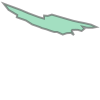

In [30]:
w = Data(world)
print(w.region[0].name)
w.region[0].polygon

Andes fueginos


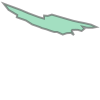

In [31]:
andes = w.region[0]
print(andes.name)
andes.polygon
#andes.get_occurrences_in_polygon()

### explicit use of Polygon class object

In [28]:
alaska = Polygon(name="alaska", polygon=world.geometry[world.Name == "Alaska Range"])
alaska.get_occurrences_in_polygon(tol = 0.5)

{'offset': 0,
 'limit': 100,
 'endOfRecords': False,
 'count': 23455,
 'results': [{'key': 2813898723,
   'datasetKey': '50c9509d-22c7-4a22-a47d-8c48425ef4a7',
   'publishingOrgKey': '28eb1a3f-1c15-4a95-931a-4af90ecb574d',
   'installationKey': '997448a8-f762-11e1-a439-00145eb45e9a',
   'publishingCountry': 'US',
   'protocol': 'DWC_ARCHIVE',
   'lastCrawled': '2021-03-21T07:12:09.319+00:00',
   'lastParsed': '2021-03-21T08:48:08.429+00:00',
   'crawlId': 256,
   'hostingOrganizationKey': '28eb1a3f-1c15-4a95-931a-4af90ecb574d',
   'extensions': {'http://rs.gbif.org/terms/1.0/Multimedia': [{'http://purl.org/dc/terms/format': 'image/jpeg',
      'http://purl.org/dc/terms/license': 'http://creativecommons.org/licenses/by-nc/4.0/',
      'http://purl.org/dc/terms/created': '2020-04-26T21:51:23Z',
      'http://purl.org/dc/terms/rightsHolder': 'jdmason',
      'http://purl.org/dc/terms/type': 'StillImage',
      'http://rs.tdwg.org/dwc/terms/catalogNumber': '80748950',
      'http://purl.or

In [34]:
# to investigate length of geometry string issue when querying GBIF (supposedly string can't be larger than 1500)
# seems like the hard limit is 5000 characters
def length(idx):
    x = world.geometry[idx]
    length = len(str(x))
    return length

In [35]:
length(778)

13042